# Organize_Learning_Data

### This script takes raw JSON data from the learning phase of the paradigm and organizes it for all participants and all trials.

#### Created by: Ziv Ben-Zion 
#### Last Updated: May 2023


In [1]:
#importing packages

import pandas as pd
import json
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import os
warnings.filterwarnings('ignore')
import numpy as np

In [2]:
#find the folders all of the subjects and creat a list of them
sublist = glob('C:\\Users\\zhb4\\Box Sync\\Neural Computations\\Online Pilot\\Raw Data\\study_result_*')

In [3]:
#This is a function used to extract a single subject data based on its JSON file (res) and subject number (sub)
def extract_sub_data(res, sub): 
    '''
    Input: 
    res- data extracted from JSON for a single subject
    sub- string representing the subject number
    Outupt:
    df- pandas DataFrame containing the extracted data.
    '''   
    # creating an empty dataframe
    df = pd.DataFrame()
    if int(sub) < 150:
        cohort = 1
    else:
        cohort = 2
    # The function loops through each trial in the JSON data file (res) and extracts relevant pieces of information, 
    # including the mean value of the stimulus and its actual value in that trial
    for i in range(len(res)):
        time = res[i]['time'] #time in Unix timestamp
        mean_stim = res[i]['cues'][0]['reward_mean'] #mean value of stimulus
        actual_stim = res[i]['cues'][0]['reward'] #actual value of stimulus in this trial

    # Determine if the trial has a reward or punishment based on the sign of the mean stimulus value
        if mean_stim > 0:
            trial_type = 'reward'
        else:
            trial_type = 'punishment'
            
    #  In trials without input we define the rating and their reaction times as NaN (Not a Number)        
        if res[i]['cues'][0]['takingInput']==False:
            val, conf, RT_val, RT_conf = np.NaN, np.NaN, np.NaN, np.NaN
    #  In trials with input, we also extract participants' value & confidence ratings for the stimulus (val, conf) 
    #  and their reaction times (RT_val,RT_conf) 
        else:
            val = ((res[i]['cues'][0]['input']['rewardLikely_UI'])-10)*10
            conf = res[i]['cues'][0]['input']['confidence_UI']
            RT_val = res[i]['cues'][0]['input']['rewardLikely_UI_rt']
            RT_conf = res[i]['cues'][0]['input']['confidence_UI_rt']

    # For each trial, the function creates a dictionary with the extracted information and creates a temporary DataFrame. 
    # These temporary DataFrames are concatenated together to create the final DataFrame with all the trials of a single subject.
        trial = {'sub': sub, 'cohort': cohort, 'time':time, 'trial': i+1, 'trial_type': trial_type, 'mean_stim': mean_stim, 
                 'actual_stim': actual_stim,'val': val, 'RT_val': RT_val, 'conf': conf, 'RT_conf': RT_conf}
        temp = pd.DataFrame(trial, index=[0])
        df = pd.concat([df, temp])
        df = df.reset_index(drop=True)
        
    df.head()
    return df

In [4]:
#Here we use the function extract_sub_data to extract a single subject dataframe based on its JSON file and subject number
df = pd.DataFrame()

for folder_path in sublist: 
    # Specify the subject number
    sub = folder_path.split("_")[-1]
    # Get the list of items in the subject folder
    items = os.listdir(folder_path)
    # Filter folders from the list
    folders = [item for item in items if os.path.isdir(os.path.join(folder_path, item))]
    # Check if there are exactly 13 folders
    if len(folders) == 13:
        # If so, sort folders alphabetically
        sorted_folders = sorted(folders, key=lambda x: int(x.split('_')[1]))
        # Retrieve the name of the 6th and 7th folders - learning block #1 and learning block #2
        learning1_folder = sorted_folders[5]
        learning2_folder = sorted_folders[6]
        # Update the folder_path with the names of the 6th and 7th folder
        folder_path_learning1 = os.path.join(folder_path, learning1_folder)
        folder_path_learning2 = os.path.join(folder_path, learning2_folder)
        
        # Extract data for learning block #1
        data_file_path_learning1 = os.path.join(folder_path_learning1, "data.txt")
        with open(data_file_path_learning1, "r") as file:
            res_learning1 = file.read()
            res_learning1 = json.loads(res_learning1)[1]['data']
            temp_learning1 = extract_sub_data(res_learning1, sub)
        
        # Extract data for learning block #2
        data_file_path_learning2 = os.path.join(folder_path_learning2, "data.txt")
        with open(data_file_path_learning2, "r") as file:
            res_learning2 = file.read()
            res_learning2 = json.loads(res_learning2)[1]['data']
            temp_learning2 = extract_sub_data(res_learning2, sub)
            
        # Concatenate the data for both learning blocks
        temp_combined = pd.concat([temp_learning1, temp_learning2])
            
        #Save the data for one subject and continue to the next 
        df = pd.concat([df,temp_combined])
        
#Now df contains the learning data for all subjects        
df = df.reset_index(drop=True)

#Save as a csv file
df.to_csv('Learning_Data_40.csv', index=False)

In [5]:
df.head()

,sub,cohort,time,trial,trial_type,mean_stim,actual_stim,val,RT_val,conf,RT_conf
0,100,1,1678836260121,1,reward,20,40,NaN,NaN,NaN,NaN
1,100,1,1678836263946,2,reward,50,50,NaN,NaN,NaN,NaN
2,100,1,1678836274896,3,reward,80,80,NaN,NaN,NaN,NaN
3,100,1,1678836277905,4,reward,50,50,80.0,7.463,7.0,1.172
4,100,1,1678836288842,5,reward,20,20,50.0,4.987,5.0,1.488


In [84]:
anx = pd.read_csv('Anxiety.csv')
df_rt['sub'] = df_rt['sub'].astype('int64')
df_corr = df_rt.merge(anx, left_on='sub', right_on='sub')
df_corr.head()

,sub,trial_type,RT_val,RT_conf,mean_stim,GAD
0,100,punishment,2.7122,1.4674,-80,12
1,100,punishment,3.3191,1.3298,-50,12
2,100,punishment,2.4436,1.2191,-20,12
3,100,reward,2.8570,1.8568,20,12
4,100,reward,3.1999,1.4508,50,12


<AxesSubplot:xlabel='GAD', ylabel='RT_conf'>

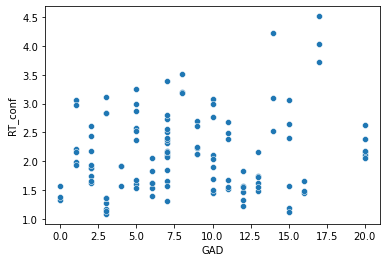

In [85]:
sns.scatterplot(data=df_corr[df_corr['trial_type']=='punishment'], x='GAD', y='RT_conf')

<AxesSubplot:xlabel='GAD', ylabel='RT_conf'>

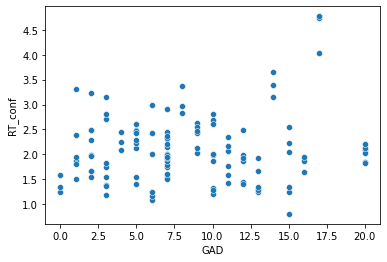

In [89]:
sns.scatterplot(data=df_corr[df_corr['trial_type']=='reward'], x='GAD', y='RT_conf')

<AxesSubplot:xlabel='GAD', ylabel='RT_val'>

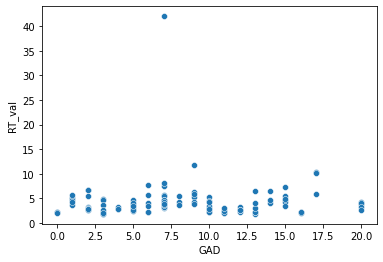

In [87]:
#average reaction time for value ranking as a function of anxiety
sns.scatterplot(data=df_corr[df_corr['trial_type']=='punishment'], x='GAD', y='RT_val')

<AxesSubplot:xlabel='GAD', ylabel='RT_val'>

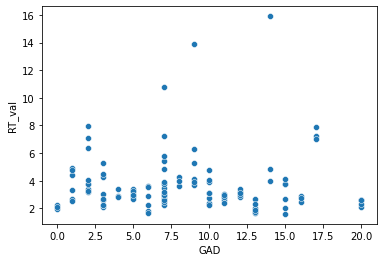

In [88]:
#average reaction time for value ranking as a function of anxiety
sns.scatterplot(data=df_corr[df_corr['trial_type']=='reward'], x='GAD', y='RT_val')

In [ ]:
#average reaction time for value ranking by type of stimuli as a function of anxiety
sns.scatterplot(data=df_corr[df_corr['trial_type']=='punishment'], x='GAD', y='RT_val', hue='mean_stim')


<AxesSubplot:xlabel='GAD', ylabel='RT_val'>

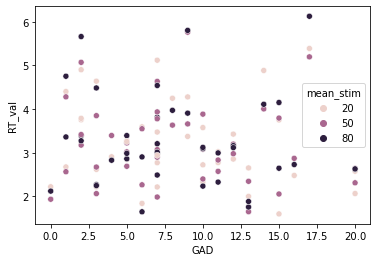

In [63]:
sns.scatterplot(data=df_corr[df_corr['trial_type']=='reward'], x='GAD', y='RT_val',hue='mean_stim')

<AxesSubplot:xlabel='RT_val', ylabel='RT_val'>

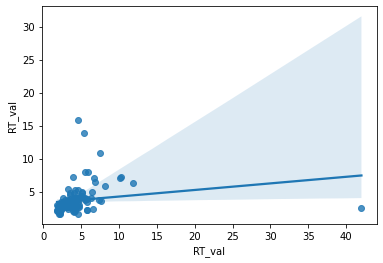

In [90]:
sns.regplot(x=df_corr[df_corr['trial_type']=='punishment']['RT_val'], y=df_corr[df_corr['trial_type']=='reward']['RT_val'])